## Setup 

In [ ]:
%%capture
!pip install kmapper

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
import kmapper as km
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Data

In [ ]:
path = "/content/drive/Shareddrives/Reto Topologia/data/enso_rain.csv"
# Read the data into a Pandas DataFrame
data = pd.read_csv(path)
# Print the first few rows of the data
print(data.head())

         Date    YR  MON  NINO3.4  ANOM.3  rain
0  1982-01-01  1982    1    26.65    0.08  4.24
1  1982-02-01  1982    2    26.54   -0.20  2.95
2  1982-03-01  1982    3    27.09   -0.14  5.78
3  1982-04-01  1982    4    27.83    0.02  3.64
4  1982-05-01  1982    5    28.37    0.49  0.22


In [ ]:
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
px.line(data, x="Date", y=["ANOM.3", "rain"])

In [ ]:
data

,Date,YR,MON,NINO3.4,ANOM.3,rain
0,1982-01-01,1982,1,26.65,0.08,4.24
1,1982-02-01,1982,2,26.54,-0.20,2.95
2,1982-03-01,1982,3,27.09,-0.14,5.78
3,1982-04-01,1982,4,27.83,0.02,3.64
4,1982-05-01,1982,5,28.37,0.49,0.22
...,...,...,...,...,...,...
491,2022-12-01,2022,12,25.81,-0.84,6.41
492,2023-01-01,2023,1,25.88,-0.69,8.25
493,2023-02-01,2023,2,26.29,-0.44,3.38
494,2023-03-01,2023,3,27.23,-0.01,7.11


In [ ]:
# Get numerical columns for Kmapper
num_cols = ["YR", "MON", "NINO3.4", "ANOM.3", "rain"]
data = data[num_cols]

## Mapper

### California Rain Dataset

In [ ]:
mapper = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


In [ ]:
%%capture
# Create a custom 1-D lens with Isolation Forest
X = data[num_cols].values

model = ensemble.IsolationForest(random_state=1729)

model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=0)

projection = [3]
lens2 = mapper.fit_transform(X, projection)

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

n_cubes = 12
perc_overlap = 0.25
# Define the simplicial complex
G = mapper.map(lens,
               X,
               cover=km.Cover(n_cubes=n_cubes, perc_overlap=perc_overlap),
               clusterer=sklearn.cluster.KMeans(n_clusters=2)
               )

Save HTML

In [ ]:
# PATH = create_path(proj="enso", color="rain", n_cubes=n_cubes, perc_overlap=perc_overlap, shift=shift)
color_str = "ANOM.3"

PATH = f"mapper__proj_{str(projection)}__n_{n_cubes}__perc_{perc_overlap}.html"

mapper.visualize(G, 
                title='ENSO',
                color_values = data[color_str].values,
                custom_tooltips = data[color_str].values,
                color_function_name = color_str,
                node_color_function=np.array(['average','std','sum','max','min']),
                path_html=PATH)

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>ENSO | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weight: 700;\n

## Outliers

### Find outliers: Union find

In [ ]:
from collections import defaultdict

class UnionFind:
    def __init__(self, links):
        self.par = {x:x for x in links}
        self.score = {x:1 for x in links}

    def find(self, cube):
        if self.par[cube] != cube:
            self.par[cube] = self.find(self.par[cube])  # Path compression
        return self.par[cube]

    def union(self, a, b):
        par_a, par_b = self.find(a), self.find(b)
        if par_a != par_b:
            self.par[par_b] = par_a
        
    def get_components(self):
        components = {}
        for node in self.par.keys():

            root = self.find(node)
            if root not in components:
                components[root] = []
            components[root].append(node)
        return components

In [ ]:
# Crear adjencency list
nodes = G["nodes"]
adj_list = defaultdict(list)

for node in nodes:
    adj_list[node] = []
    for nei in G["links"][node]:
        adj_list[node].append(nei)
        adj_list[nei].append(node)

# Correr Union-Find
uf = UnionFind(adj_list)
for node in nodes:
    for nei in adj_list[node]:
        uf.union(node, nei)

In [ ]:
components = uf.get_components()

In [ ]:
"""
CREAR MAPS

map_node_idxs [node_parent: list_children_idxs]
    node_parent: Nombre node parent e.g. (cube45_cluster1)
    list_childre_idxs: Lista de indices que son hijos (estan conectados) al padre

map_idx_node [child_idx: node_parent]
    child_idx: Entero que representa un nodo
    node_parent: Nombre node parent e.g. (cube45_cluster1)
"""

map_node_idxs = defaultdict(set)
map_idx_node = {}
for parent, children in components.items():
    for child in children:
        for idx in G["nodes"][child]:
            map_node_idxs[parent].add(idx)
            map_idx_node[idx] = parent

In [ ]:
# Esta función puede parecer innecesaria, por alguna razoón algunos idx no se generan en el mapper.
def get_parent_from_idx(idx):
    if idx in map_idx_node:
        return map_idx_node[idx]
    else:
        print(f"{idx} not found")
        return get_parent_from_idx(idx-1)
        
data["parent"] = pd.Series(data.index).apply(get_parent_from_idx)

<ipython-input-103-97caa7a6f8ca>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Cantidad de hijos que tiene cada padre.
data["parent"].value_counts()

cube52_cluster1    463
cube18_cluster0      5
cube6_cluster1       4
cube7_cluster1       3
cube8_cluster1       3
cube0_cluster0       2
cube16_cluster0      2
cube10_cluster0      2
cube1_cluster0       2
cube2_cluster1       2
cube32_cluster1      1
cube1_cluster1       1
cube8_cluster0       1
cube2_cluster0       1
cube6_cluster0       1
cube9_cluster1       1
cube16_cluster1      1
cube0_cluster1       1
Name: parent, dtype: int64

### Group by parent/ Analysis

In [ ]:
single_nodes = data["parent"].value_counts()[data["parent"].value_counts() < 2].index
data = data[~data["parent"].isin(single_nodes)]

In [ ]:
data["parent"].value_counts()

cube52_cluster1    463
cube18_cluster0      5
cube6_cluster1       4
cube7_cluster1       3
cube8_cluster1       3
cube0_cluster0       2
cube16_cluster0      2
cube10_cluster0      2
cube2_cluster1       2
cube1_cluster0       2
Name: parent, dtype: int64

In [ ]:
fig = px.violin(data, y='ANOM.3', x='parent', points='all', title='Distribution per Cluster')
fig.show()

#fig = px.scatter(data, x='parent', y='ANOM.3', title='Enso per Parent Node', color="rain")
#fig.show()

In [ ]:
data[data["parent"] == "cube35_cluster0"]

,YR,MON,NINO3.4,ANOM.3,parent


In [ ]:
data[data["parent"] == "cube28_cluster1"]

,YR,MON,NINO3.4,ANOM.3,rain,parent
395,2014,12,27.28,0.63,6.30,cube28_cluster1
444,2019,1,27.24,0.67,5.23,cube28_cluster1
445,2019,2,27.44,0.71,8.57,cube28_cluster1
455,2019,12,27.08,0.44,4.87,cube28_cluster1


## EDA

### Cross-Correlation Analysis

<ipython-input-117-adb21370d67e>:11: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead.



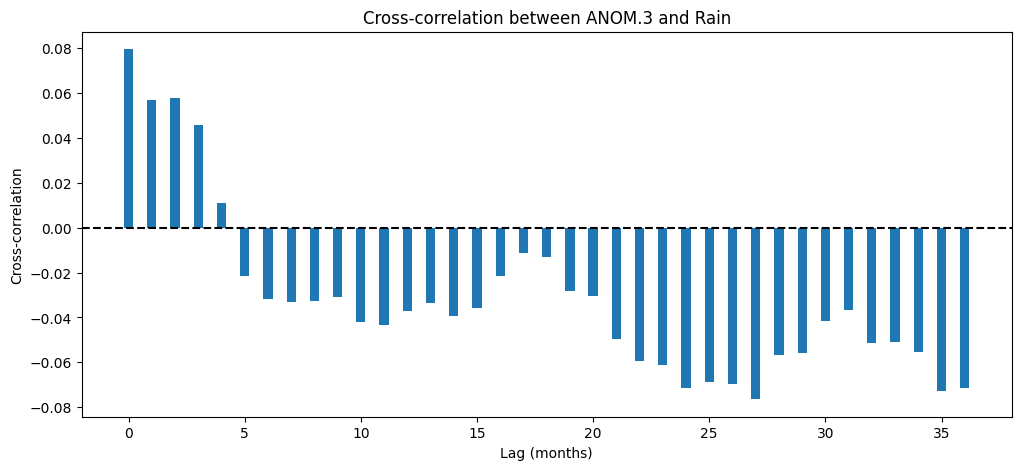

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# assuming 'data' is your DataFrame and it is indexed with a datetime index
anom3 = (data['ANOM.3'] - data['ANOM.3'].mean()) / data['ANOM.3'].std()
rain = (data['rain'] - data['rain'].mean()) / data['rain'].std()

lag = np.arange(37)  # we are going to check lags from 1 to 24 months

ccf_values = ccf(anom3, rain, unbiased=True)

plt.figure(figsize=(12,5))
plt.bar(lag, ccf_values[lag], width=0.4)
plt.axhline(y=0, linestyle='--', color='black')  # add a horizontal zero line
plt.xlabel('Lag (months)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between ANOM.3 and Rain')
plt.show()

In [ ]:
rain

0      1.096907
1      0.504723
2      1.803856
3      0.821473
4     -0.748505
         ...   
491    2.093063
492    2.937729
493    0.702118
494    2.414403
495   -0.597016
Name: rain, Length: 496, dtype: float64